## 1. Introduction

In this section, we generate sample paths of a one-dimensional Brownian motion and then visualize them. Specifically, we will:

1. Define the number of time steps `t` and the number of paths `s`.
2. Draw random increments from a normal distribution.
3. Construct the Brownian paths by cumulatively summing these increments.
4. Plot the resulting paths.

The code cell below shows how we generate and plot these paths.


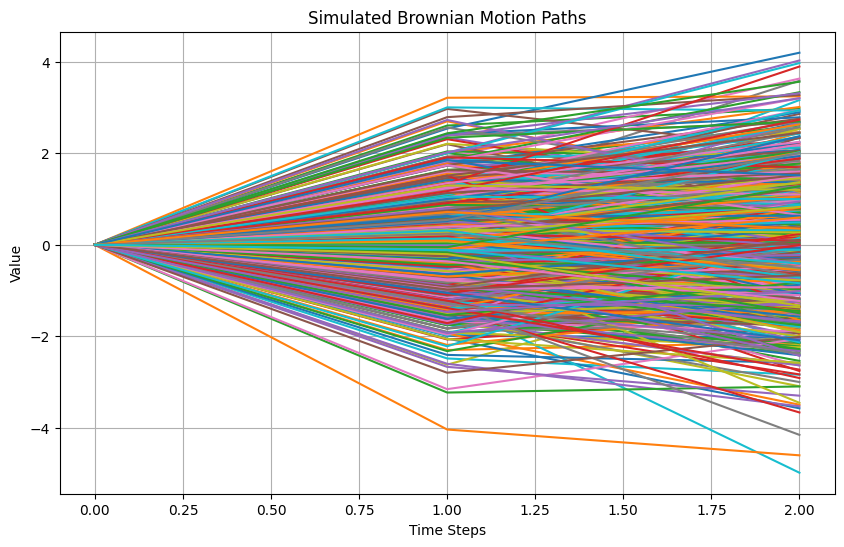

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 3  # Number of time steps
s = 800  # Number of paths

# Generate Brownian motion paths
incs = np.random.normal(size=[s, T-1])
bms = np.cumsum(incs, axis=1)
bms = np.concatenate([np.zeros([s, 1]), bms], axis=1)

# Time points for plotting
time_points = np.arange(bms.shape[1])

# Plot each path
plt.figure(figsize=(10, 6))
for path in bms:
    plt.plot(time_points, path)

plt.title("Simulated Brownian Motion Paths")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.grid(True)
plt.show()

## 2. The `empirical_k_means_measure` Function

Next, we define a function `empirical_k_means_measure` that clusters sample paths (or increments) using **K-Means** and returns either:

- A new set of representative paths (if `use_weights=0`).  
- A set of representative paths alongside their weights (if `use_weights=1`).

This allows us to build an **adapted** empirical measure following the methodology described by **Backhoff et al. (2022)**:

> BACKHOFF, J., BARTL, D., BEIGLBÖCK, M. and WIESEL, J. (2022). *Estimating processes in adapted Wasserstein distance*. The Annals of Applied Probability, 32(1), 529–550.

The main idea is:
1. For each time step, cluster the values across paths.
2. Replace these values with the cluster centers.
3. Optionally, compute the weights of each unique path formed by these cluster centers.

**Key Parameters**  
- `data` : \((k, T_h)\)-shaped array of \(k\) paths, each of length \(T_h\).  
- `use_klist`: If `1`, uses the provided list `klist` to determine the **number of clusters per time step**.  
- `klist`: A list containing the desired number of clusters for each time step. By default, this is chosen to be \(\sqrt{k}\), i.e., the square root of the total number of paths.  
- `tol_decimals`: Number of decimal places to round the cluster centers.  
- `use_weights`: If `1`, returns both \((\text{paths}, \text{weights})\). If `0`, returns only the cluster-center paths.  
- `heuristic`: If `1`, uses a simple binning approach instead of K-Means for clustering.

Below is the code that provides the full implementation of this function.



In [2]:
from sklearn.cluster import KMeans

# FUNCTION THAT PRODUCES ADAPTED EMPIRICAL MEASURE USING KMEANS
# Basically implements the methodology of Backhoff et al "Estimating processes in adapted Wasserstein distance"
# However, instead of the fixed grid based approach therein, we use K-Means to cluster the points together, which is
# more flexible with respect to varying orders of magnitude etc
def empirical_k_means_measure(data, use_klist=0, klist=(), tol_decimals=6, use_weights=0, heuristic=0):
    # data is [k, T_h] array
    # klist is list with T_h entries, each being an integer lower than k; number of barycenters for each time step
    (k, T_h) = data.shape
    if not use_klist:
        klist = (np.ones(T_h) * int(np.round(np.sqrt(k)))).astype(int)

    label_list = []
    support_list = []
    out_x = np.zeros([0, T_h])
    out_w = []

    # cluster points at each time point
    # print('Clustering...')
    if heuristic:
        for t in range(T_h):
            data_t = data[:, t]
            inds_sort_t = np.argsort(data_t)
            datas_t = data_t[inds_sort_t]
            n_av = int(np.round(k/klist[t]))
            lmax = int(np.floor(n_av * klist[t]))
            all_but_end = np.reshape(datas_t[:lmax], (-1, n_av))
            mean_all_but = np.mean(all_but_end, axis=1, keepdims=1)
            cx = mean_all_but
            mean_all_but = np.tile(mean_all_but, (1, n_av))
            mean_all_but = np.reshape(mean_all_but, (-1, 1))
            mean_rest = np.mean(datas_t[lmax:])
            if lmax < k:
                mean_vec = np.concatenate([np.squeeze(mean_all_but), np.array([mean_rest])])
                cx = np.concatenate([cx, np.array([mean_rest])])
            else:
                mean_vec = np.squeeze(mean_all_but)
            lx = np.zeros(k, dtype=int)
            for i in range(k):
                for j in range(len(cx)):
                    if mean_vec[inds_sort_t[i]] == cx[j]:
                        lx[i] = j
                        continue
            label_list.append(lx)
            support_list.append(cx)

    else:
        for t in range(T_h):
            # print('t = ' + str(t))
            data_t = data[:, t:t+1]
            n_clusters = min(klist[t], len(np.unique(data_t, axis=0)))
            
            #print(f"Number of clusters: {n_clusters}")
            #print(f"KList value: {klist[t]}")
            #print(f"Number of unique values in the dataset: {len(np.unique(data_t, axis=0))}")

            kmx = KMeans(n_clusters, n_init='auto').fit(data_t)
            cx = kmx.cluster_centers_
            cx = np.round(cx, decimals=tol_decimals)
            lx = kmx.labels_
            
            #print("Our Data Points (data_t):")
            #print(data_t)
            #print("\nClusters Found (cx):")
            #print(cx)
            #print("\nTable of Clusters (lx):")
            #print(lx)

            label_list.append(lx)
            support_list.append(cx)

    if use_weights == 0:  # weight all cluster centers equally? ... Convenient but theoretically flawed I think
        out = np.zeros([k, T_h])
        for t in range(T_h):
            out[:, t] = support_list[t][label_list[t]][:, 0]
        return out

    # build output measure
    for i in range(k):
        cur_path = np.zeros(T_h)
        for t in range(T_h):
            cur_path[t] = support_list[t][label_list[t][i]].item()

        # check whether the path already exists
        path_is_here = 0
        for j in range(len(out_w)):
            if np.all(out_x[j, :] == cur_path):
                out_w[j] += 1 / k
                path_is_here = 1
                break
        if not path_is_here:
            out_x = np.append(out_x, np.expand_dims(cur_path, axis=0), axis=0)
            out_w.append(1 / k)

    return out_x, out_w

## 3. Constructing the Adapted Measure

Finally, we apply `empirical_k_means_measure` to the Brownian motion paths with `use_weights=1`, so we receive:

- `out_x`: The support of our adapted measure (the set of unique clustered paths).  
- `out_w`: The corresponding weights for each path. These weights are **typically** uniformly distributed, except in cases where paths appear more than once (duplicates), in which case the weight mass is aggregated.

We then visualize the representative (clustered) paths to see how well they capture the structure of the original Brownian paths.

Below is the code that computes and plots the adapted measure.

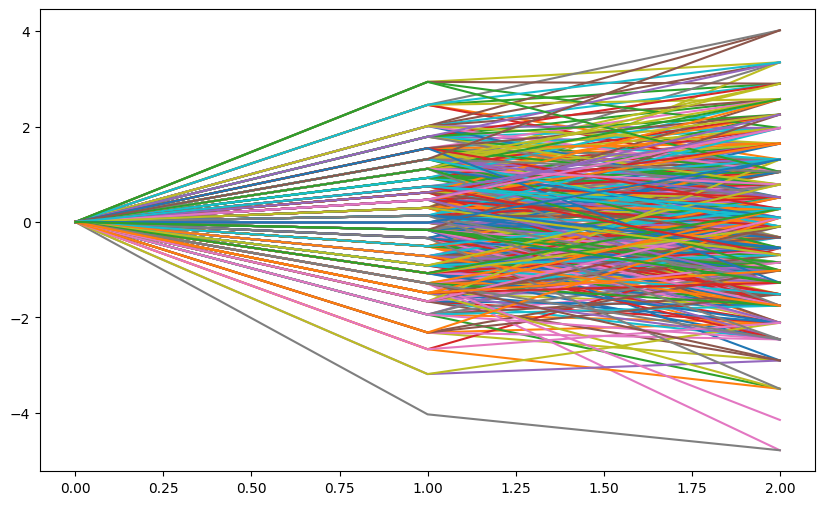

In [3]:
out_x, out_w = empirical_k_means_measure(bms, use_weights=1)

# Time points for plotting
time_points = np.arange(out_x.shape[1])

# Plot each path
plt.figure(figsize=(10, 6))
for path in out_x:
    plt.plot(time_points, path)

mu_full_ad = [out_x, out_w]

## 4. A Custom `Graph` Class for Topological Sorting

In the cell below, we define a custom `Graph` class that stores vertices and edges in adjacency lists. The class includes:

- A constructor that initializes a `defaultdict(list)` for adjacency.
- Methods for adding edges between vertices, which also keeps track of parent-child relationships.
- THIS IS NOT RELEVANT FOR US: A `topologicalSort` method that performs a **topological sorting** of the graph via a depth-first search (DFS).

In [4]:
from collections import defaultdict

# CLASS FOR GRAPHS FOR REPRESENTING FUNCTIONS
# taken from https://www.geeksforgeeks.org/python-program-for-topological-sorting/
# Class to represent a graph
class Graph:
    def __init__(self, vertices):
        self.graph = defaultdict(list)  # dictionary containing adjacency List
        self.V = vertices  # No. of vertices
        self.parents = defaultdict(list)

    # function to add an edge to graph
    def addEdge(self, u, v):
        self.graph[u].append(v)
        self.parents[v].append(u)

        # A recursive function used by topologicalSort

    def topologicalSortUtil(self, v, visited, stack):

        # Mark the current node as visited.
        visited[v] = True

        # Recur for all the vertices adjacent to this vertex
        for i in self.graph[v]:
            if visited[i] == False:
                self.topologicalSortUtil(i, visited, stack)

                # Push current vertex to stack which stores result
        stack.insert(0, v)

        # The function to do Topological Sort. It uses recursive

    # topologicalSortUtil()
    def topologicalSort(self):
        # Mark all the vertices as not visited
        visited = [False] * self.V
        stack = []

        # Call the recursive helper function to store Topological
        # Sort starting from all vertices one by one
        for i in range(self.V):
            if visited[i] == False:
                self.topologicalSortUtil(i, visited, stack)

                # Print contents of stack
        return stack

## 5. Generating a Trinomial Measure

Here, we define a function `trinomial()` that returns two objects:

1. `mu(node, x_parents)`: A function that, given a node index (time step) and its parent’s state(s), outputs the support and weights of possible child states. In this code, we model a **trinomial** random step (e.g., going up, staying the same, or going down with equal probability).

2. `sup_mu(node_list)`: A function that, given a list of node indices, returns the full support set (all combinations of states) for those nodes. If there is only one node in the list, it returns the states from \(-t\) to \(+t\). If there are multiple nodes, it creates the product set of states for all those nodes.

This allows us to construct a simple Markov measure that evolves over time by moving up, down, or staying put with probability \(1/3\) each.


In [5]:
def trinomial():
    # returns a measure which corresponds to a binomial model on a T time steps specified corresponding to its
    # natural graph, which is the temporal markovian graph.

    def mu(node, x_parents):
        if node == 0:
            return [[0], [1]]
        else:
            x = x_parents[0]  # should only contain one element as the structure is Markovian
            return [[x-1, x, x+1], [1/3, 1/3, 1/3]]

    def sup_mu(node_list):
        if len(node_list) == 0:
            out = np.array([])
            out = out.reshape(-1, 1)
            return out
        if len(node_list) == 1:
            t = node_list[0]  # we only need to supply support for single element node-lists, as no two nodes share a child
            sup_l = [x for x in range(-t, t+1)]
        else:
            lol = []
            node_list_c = sorted(list(node_list))
            for t in node_list_c:
                lol.append([x for x in range(-t, t + 1)])
            sup_l = list(product(*lol))
        bt = len(node_list)
        return np.reshape(np.array(sup_l), (-1, bt))
    return mu, sup_mu

## 6. Reducing the Representation of Measures

The function `reduce_meas(marg, filt=0)` takes a measure, which is represented by:
- A (potentially large) array of points (paths or states).
- A list (or array) of corresponding weights.

It identifies **duplicate** points in the array (i.e., identical paths or states) and **merges** them by summing their weights. This reduces the size of the representation if multiple entries correspond to the same point. 

This is especially useful in scenarios where clustering or combinatorial expansions create repeated states.


In [6]:
# FUNCTION TO CHANGE REPRESENTATION OF MEASURES
def reduce_meas(marg, filt=0):
    # marg is a list with two entries, one n x d np array, and one n-list of weights
    # the goal of this function is to identify duplicates in the first entry and reduce the representation
    if filt == 1:
        return marg  # TODO: check how to reduce in this case as well ...
    if len(marg[0].shape) == 1:
        marg[0].reshape(-1, 1)
    uniques, inv = np.unique(marg[0], axis=0, return_inverse=1)
    w_new = np.zeros(len(uniques))
    for l in range(len(marg[0])):
        w_new[inv[l]] += marg[1][l]
    # for i in range(len(uniques)):
    #     for l in range(len(marg[0])):
    #         if np.all(uniques[i, :] == marg[0][l, :]):
    #             w_new[i] += marg[1][l]
    return [uniques, w_new]

## 7. Computing Joint Marginals from a Markovian Graph

We then define `get_marginals_multi(mu, supp_mu, node_set, g, given_margs, ...)`. This function:

- Takes a measure in a **disintegrated** form (i.e., `mu` and `supp_mu` describing local conditional transitions).
- Uses the structure of a **Markovian graph** (or any DAG) to build the **joint distribution** over a specified subset of nodes, `node_set`.
- Recursively calls itself on the parents of each node to accumulate partial or full marginals. 
- Optionally merges or reduces the final measure to account for duplicates.

This approach generalizes the idea of constructing marginals in a Markov chain by sequentially expanding states and applying transition probabilities.

In [7]:
from itertools import product

def get_marginals_multi(mu, supp_mu, node_set, g, given_margs, all_out=0, index_mu=0, tol=10**-6, filt=0):
    # function should get a joint distribution on the specified node set. I.e., we want to go from disintegration
    # representation of a measure towards specifying the joint distribution.
    # node_set is a tuple containing the nodes that we wish to calculate the joint marginal on

    # get relevant parents
    rel_par = []
    for nh in node_set:
        rel_par.extend(g.parents[nh].copy())
    rel_par = list(tuple(rel_par))
    rel_par.sort()
    rel_par = tuple(rel_par)
    rel_par_arr = np.array(rel_par)

    # for each node in node_set, get the indices of the respective parents in rel_par
    # rel_par_arr[indices[j]] will give the parents of node_set[j]
    indices = []
    for nh in node_set:
        ph = g.parents[nh].copy()
        index = np.zeros(len(ph), dtype=int)
        for ind0, i in enumerate(ph):
            for ind in range(len(rel_par)):
                if rel_par[ind] == i:
                    index[ind0] = ind
        indices.append(index)

    # get relevant marginal rel_marg of the form [ n x d array, list of weights]
    if len(rel_par) == 0:
        # for each node in node_set, get the parent values from xh
        x_lists = []
        w_lists = []
        if filt == 1:
            filt_list_a = []
            filt_list_b = []
        for ind, nh in enumerate(node_set):
            if index_mu == 0:
                marg_x_nh = mu(nh, [])
            else:
                marg_x_nh = mu(nh, 0)
            if len(np.array(marg_x_nh[0]).shape) == 2:
                x_lists.append(marg_x_nh[0][:, 0])  # marg_x_nh[0] is always of shape [n, 1]
                if filt == 1:
                    filt_list_a.append(marg_x_nh[2][:, 0])
                    filt_list_b.append(marg_x_nh[2][:, 1])
            else:
                x_lists.append(marg_x_nh[0])
                if filt == 1:
                    filt_list_a.append(marg_x_nh[2][:, 0])
                    filt_list_b.append(marg_x_nh[2][:, 1])

            w_lists.append(marg_x_nh[1])

        x_list_comb = list(product(*x_lists))
        if filt == 1:
            filt_a_comb = list(product(*filt_list_a))
            filt_b_comb = list(product(*filt_list_b))
            a_arr = np.array(filt_a_comb)
            b_arr = np.array(filt_b_comb)
            if len(a_arr.shape) == 1:
                a_arr = a_arr.reshape(-1, 1)
            if len(b_arr.shape) == 1:
                b_arr = b_arr.reshape(-1, 1)
            filt_tot = np.append(a_arr, b_arr, axis=1)
            w_list_comb = list(product(*w_lists))
            w_list_comb = [np.prod(w_here) for w_here in w_list_comb]
            marg_add = [np.array(x_list_comb), w_list_comb, filt_tot]
        else:
            w_list_comb = list(product(*w_lists))
            w_list_comb = [np.prod(w_here) for w_here in w_list_comb]
            marg_add = [np.array(x_list_comb), w_list_comb]
            marg_add = reduce_meas(marg_add, filt=filt)

        if all_out == 0:
            return marg_add
        else:
            node_set = list(node_set)
            node_set.sort()
            given_margs[tuple(node_set)] = marg_add
            return given_margs
    elif not rel_par in given_margs:
        if all_out == 0:
            rel_marg = get_marginals_multi(mu, supp_mu, rel_par, g, given_margs, index_mu=index_mu, filt=filt)
        else:
            all_margs = get_marginals_multi(mu, supp_mu, rel_par, g, given_margs, all_out=1, index_mu=index_mu, filt=filt)
            rel_marg = all_margs[rel_par]
    else:
        rel_marg = given_margs[rel_par]
        all_margs = given_margs

    # calculate the joint marginal of node_set given the joint marginal of all the relevant parents:
    d = len(node_set)
    out_x = np.zeros([0, d])
    out_w = []
    if filt == 1:
        out_f = np.zeros([0, 2*d])
    if index_mu == 1:
        if filt == 1:
            supp_rel_p = supp_mu(rel_par, filt=1)
            supp_rel = supp_rel_p[0]
            filt_rel = supp_rel_p[1]
        else:
            supp_rel = supp_mu(rel_par)
    for i in range(len(rel_marg[0])):
        xh = rel_marg[0][i, :]
        wh = rel_marg[1][i]
        if filt == 1:
            fh = rel_marg[2][i, :]  # filtration of marginal; second dimension should be double that of xh
        if wh == 0:
            continue

        if index_mu == 1:
            ind_rel_here = -1
            for j in range(len(supp_rel)):
                if filt == 0:
                    if np.all(np.abs(xh - supp_rel[j, :]) < tol):
                        ind_rel_here = j
                        break
                else:
                    if np.all(np.abs(xh - supp_rel[j, :]) < tol) and np.all(np.abs(fh - filt_rel[j, :]) < tol):
                        ind_rel_here = j
                        break
            if ind_rel_here == -1:
                print('ERROR: relevant support point not found...')

        # for each node in node_set, get the parent values from xh
        x_lists = []
        w_lists = []
        if filt == 1:
            filt_list_a = []
            filt_list_b = []
        for ind, nh in enumerate(node_set):
            if nh in rel_par:
                ind_nh = np.where(nh == rel_par_arr)[0][0]
                x_lists.append([xh[ind_nh]])
                w_lists.append([1])
                if filt == 1:
                    filt_list_a.append([fh[ind_nh]])
                    filt_list_b.append([fh[len(rel_par)+ind_nh]])
            else:
                if len(indices[ind]) > 0:
                    rel_x = xh[indices[ind]]
                    if filt == 1:
                        rel_filt_a = fh[indices[ind]]
                        rel_filt_b = fh[len(rel_par)+indices[ind]]

                else:
                    rel_x = []
                    if filt == 1:
                        rel_filt_a = []
                        rel_filt_b = []
                if index_mu == 0:
                    marg_x_nh = mu(nh, rel_x)
                else:
                    marg_x_nh = mu(nh, ind_rel_here)
                if len(np.array(marg_x_nh[0]).shape) == 2:
                    x_lists.append(marg_x_nh[0][:, 0])  # marg_x_nh[0] is always of shape [n, 1]
                    if filt == 1:
                        filt_list_a.append(marg_x_nh[2][:, 0])
                        filt_list_b.append(marg_x_nh[2][:, 1])
                else:
                    x_lists.append(marg_x_nh[0])
                    if filt == 1:
                        filt_list_a.append(marg_x_nh[2][:, 0])
                        filt_list_b.append(marg_x_nh[2][:, 1])

                w_lists.append(marg_x_nh[1])

        if filt == 1:
            filt_a_comb = list(product(*filt_list_a))
            filt_b_comb = list(product(*filt_list_b))
            a_arr = np.array(filt_a_comb)
            b_arr = np.array(filt_b_comb)
            if len(a_arr.shape) == 1:
                a_arr = a_arr.reshape(-1, 1)
            if len(b_arr.shape) == 1:
                b_arr = b_arr.reshape(-1, 1)
            filt_tot = np.append(a_arr, b_arr, axis=1)
            x_list_comb = list(product(*x_lists))
            w_list_comb = list(product(*w_lists))
            w_list_comb = [np.prod(w_here)*wh for w_here in w_list_comb]
            marg_add = [np.array(x_list_comb), w_list_comb, filt_tot]
            out_x = np.append(out_x, marg_add[0], axis=0)
            out_w.extend(marg_add[1])
            out_f = np.append(out_f, filt_tot, axis=0)
        else:
            x_list_comb = list(product(*x_lists))
            w_list_comb = list(product(*w_lists))
            w_list_comb = [np.prod(w_here)*wh for w_here in w_list_comb]
            marg_add = [np.array(x_list_comb), w_list_comb]
            marg_add = reduce_meas(marg_add, filt=filt)
            out_x = np.append(out_x, marg_add[0], axis=0)
            out_w.extend(marg_add[1])

    if filt == 1:
        marg_out = [out_x, out_w, out_f]
    else:
        marg_out = [out_x, out_w]
    if all_out == 0:
        return reduce_meas(marg_out, filt=filt)
    else:
        node_set = list(node_set)
        node_set.sort()
        if tuple(node_set) not in all_margs:
            all_margs[tuple(node_set)] = reduce_meas(marg_out, filt=filt)
        for key in given_margs:
            if key not in all_margs:
                all_margs[key] = given_margs[key]
        return all_margs

## 8. Assembling the Markovian Structure and Generating the Full Marginal

Finally, we create a **Graph** with `T` nodes (from 0 to `T-1`), where each node has a directed edge to the next time step (forming a simple chain). We then:

1. **Add edges** in a simple chain form: `(t) -> (t+1)`.
2. **Obtain** the trinomial measure (`nu`) and its support (`supp_nu`).
3. **Call** `get_marginals_multi(nu, supp_nu, list(range(T)), g, [])` to compute the **joint distribution** of all \(T\) nodes.

`nu_marg_full` will then hold a representation of the measure over the entire time horizon, adhering to the trinomial transitions.


In [8]:
# Markovian structure:
g = Graph(T)
for t in range(T - 1):
    g.addEdge(t, t + 1)
nu, supp_nu = trinomial()
nu_marg_full = get_marginals_multi(nu, supp_nu, list(range(T)), g, [])

## 9. Defining a Cost Function for Optimal Transport

We define `f_1(x, y)` to be the $l_1$-distance between \(x\) and \(y\), i.e., $\sum |x - y|$. This function will serve as the cost function in our optimal transport problem.

In [9]:
def f_1(x, y):
    return np.sum(np.abs(x - y))

## 10. A Gurobi-Based Solver for (Bi-)Causal Optimal Transport

In the cell below, we provide a function `gurobi_bm(...)` that sets up and solves a **linear program** for optimal transport under various constraints:

- **Marginal constraints**: Ensuring that the total flow out of each point in measure 1 equals its probability, and likewise for measure 2.
- **Causal or anticausal constraints**: If specified, adds constraints that enforce a *causal* or *anticausal* coupling, relevant for *causal/Markovian optimal transport* problems.
- **Objective**: We can minimize or maximize the total cost, which is computed by summing `f(x, y)` times the coupling variable $\pi_{x,y}$.

We use **Gurobi** to solve the resulting LP. The function returns either the optimal objective value or both the optimal value and the corresponding coupling matrix, depending on the parameters.


In [10]:
from gurobipy import *
# FUNCTION TO DIRECTLY SOLVE CAUSAL AND BICAUSAL OT VIA LINEAR PROGRAMMING
def gurobi_bm(margs, f, p_dist=2, radial_cost=0, f_id=0, minmax='min', r_opti=0, outputflag=1, causal=0, anticausal=0):
    """
    :param margs: list with 2 entries, each entry being a discrete probability measure on R^n, where x_list is an [N, n] array
    :param f: function that takes two inputs, x, y, where the inputs are of the form as in the representation of the
    points in margs. Returns a single value
    :param p_dist: if radial cost is used, then this describes the Lp norm which is used.
    :param radial_cost: If 1, then f takes an arbitrary number of inputs but treats them element-wise. Each element
    which will be \|x-y\|_{p_dist} for some x, y. This allows for a faster computation of the cost matrix.
    :param f_id: if non-zero and raidal_cost nonzero, then f will be treated as the identity function.
    :param minmax: if 'min', then we minimize objective, else, we maximize
    :param r_opti: if 0, does not return optimizer. if 1, it does
    :return: optimal value (and optimizer) of the OT problem
    """
    # get relevant data from input:
    m1 = margs[0]
    m2 = margs[1]
    xl_1 = np.array(m1[0])
    xl_2 = np.array(m2[0])
    pl_1 = m1[1]
    pl_2 = m2[1]
    n1, n_dim = xl_1.shape
    n2 = len(xl_2)

    if len(xl_1.shape) == 1:
        xl_1 = xl_1.reshape(-1, 1)
    if len(xl_2.shape) == 1:
        xl_2 = xl_2.reshape(-1, 1)

    # build cost matrix:
    # print('Building cost matrix...')
    if radial_cost == 0:
        cost_mat = np.zeros([n1, n2])
        for i in range(n1):
            for j in range(n2):
                cost_mat[i, j] = f(xl_1[i, :], xl_2[j, :])
    else:
        cost_mat = np.linalg.norm(xl_1[:, None, :] - xl_2[None, :, :], axis=-1, ord=p_dist)
        if f_id == 0:
            cost_mat = f(cost_mat)

    # initialize model
    # print('Initializing model...')
    m = Model('Primal')
    if outputflag == 0:
        m.setParam('OutputFlag', 0)
    pi_var = m.addVars(n1, n2, lb=0, ub=1, name='pi_var')

    # add marginal constraints
    # print('Adding constraints...')
    m.addConstrs((pi_var.sum(i, '*') == pl_1[i] for i in range(n1)), name='first_marg')
    m.addConstrs((pi_var.sum('*', i) == pl_2[i] for i in range(n2)), name='second_marg')

    # add causal constraint: (Note: doesn't seem very efficient, but not sure how else to do)
    causal_count = 0
    if causal == 1:
        for t in range(1, n_dim):
            x_t_arr, ind_inv = np.unique(xl_1[:, :t], axis=0, return_inverse=True)
            for ind_t in range(len(x_t_arr)):
                pos_h = np.where(ind_inv == ind_t)[0]
                y_t_arr, ind_inv_y = np.unique(xl_2[:, :t], axis=0, return_inverse=True)
                for ind_t_y in range(len(y_t_arr)):
                    pos_h_y = np.where(ind_inv_y == ind_t_y)[0]
                    x_tp_arr, ind_inv_p = np.unique(xl_1[pos_h, :t+1], axis=0, return_inverse=True)
                    for ind_xp in range(len(x_tp_arr)):
                        pos_xtp = np.where(ind_inv_p == ind_xp)[0]
                        pos_xtp_real = pos_h[pos_xtp]
                        pi_sum_left = 0
                        for i_x in pos_xtp_real:
                            for i_y in pos_h_y:
                                pi_sum_left += pi_var[i_x, i_y]
                        pi_sum_right = 0
                        for i_x in pos_h:
                            for i_y in pos_h_y:
                                pi_sum_right += pi_var[i_x, i_y]
                        mu_sum_left = 0
                        for i_x in pos_h:
                            mu_sum_left += pl_1[i_x]
                        mu_sum_right = 0
                        for i_x in pos_xtp_real:
                            mu_sum_right += pl_1[i_x]

                        causal_count += 1
                        m.addConstr(pi_sum_left * mu_sum_left == pi_sum_right * mu_sum_right, name='causal_'+
                                                           str(t)+'_'+str(ind_t)+'_'+str(ind_t_y)+'_'+str(ind_xp))

    if anticausal == 1:
        for t in range(1, n_dim):
            x_t_arr, ind_inv = np.unique(xl_2[:, :t], axis=0, return_inverse=True)
            for ind_t in range(len(x_t_arr)):
                pos_h = np.where(ind_inv == ind_t)[0]

                y_t_arr, ind_inv_y = np.unique(xl_1[:, :t], axis=0, return_inverse=True)
                for ind_t_y in range(len(y_t_arr)):
                    pos_h_y = np.where(ind_inv_y == ind_t_y)[0]

                    x_tp_arr, ind_inv_p = np.unique(xl_2[pos_h, :t+1], axis=0, return_inverse=True)
                    # TODO: note that we have to concatenate pos_h and pos_p to get real index! (done, but good to keep in mind)

                    for ind_xp in range(len(x_tp_arr)):
                        pos_xtp = np.where(ind_inv_p == ind_xp)[0]
                        pos_xtp_real = pos_h[pos_xtp]

                        pi_sum_left = 0
                        for i_x in pos_xtp_real:
                            for i_y in pos_h_y:
                                pi_sum_left += pi_var[i_y, i_x]

                        pi_sum_right = 0
                        for i_x in pos_h:
                            for i_y in pos_h_y:
                                pi_sum_right += pi_var[i_y, i_x]

                        mu_sum_left = 0
                        for i_x in pos_h:
                            mu_sum_left += pl_2[i_x]

                        mu_sum_right = 0
                        for i_x in pos_xtp_real:
                            mu_sum_right += pl_2[i_x]

                        m.addConstr(pi_sum_left * mu_sum_left == pi_sum_right * mu_sum_right, name='anticausal_'+str(t)+'_'+str(ind_t)+'_'+str(ind_t_y)+'_'+str(ind_xp))

    # Specify objective function
    if minmax == 'min':
        obj = quicksum([cost_mat[i, j] * pi_var[i, j] for i in range(n1) for j in range(n2)])
        m.setObjective(obj, GRB.MINIMIZE)
    else:
        obj = quicksum([cost_mat[i, j] * pi_var[i, j] for i in range(n1) for j in range(n2)])
        m.setObjective(obj, GRB.MAXIMIZE)

    # solve model
    m.optimize()
    objective_val = m.ObjVal

    if r_opti == 0:
        return objective_val
    else:
        return objective_val, [[pi_var[i, j].x for j in range(n2)] for i in range(n1)]

In [11]:
val0, _ = gurobi_bm([mu_full_ad, nu_marg_full], f=f_1, r_opti=1, causal=1, anticausal=1, outputflag=0)
print(val0)

Set parameter Username
Set parameter LicenseID to value 2604970
Academic license - for non-commercial use only - expires 2026-01-03
0.872925645007297


Now I need to compare with my trees:

In [12]:
tree_1 = [[[10, 10, 12, 13], [10, 10, 12, 10], [10, 10, 8, 9], [10, 10, 8, 6]], [0.1836, 0.1564, 0.1584, 0.5016]]

# Convert the first part (list of lists) to a numpy array
array_part_1 = np.array(tree_1[0])

# Convert the second part (list of probabilities) to a numpy array
probabilities_part_1 = np.array(tree_1[1])

# Combine them into the required format
formatted_tree_1 = [array_part_1, probabilities_part_1]

print(formatted_tree_1)

[array([[10, 10, 12, 13],
       [10, 10, 12, 10],
       [10, 10,  8,  9],
       [10, 10,  8,  6]]), array([0.1836, 0.1564, 0.1584, 0.5016])]


In [14]:
tree_2 = [[[10, 13, 14, 15], [10, 13, 14, 14], [10, 13, 14, 13], [10, 13, 11, 12], [10, 13, 11, 10], [10, 7, 8, 9], [10, 7, 8, 7], [10, 7, 5, 6], [10, 7, 5, 4]], [0.03, 0.006, 0.024, 0.144, 0.096, 0.028, 0.042, 0.189, 0.441]]

# Convert the first part (list of lists) to a numpy array
array_part_2 = np.array(tree_2[0])

# Convert the second part (list of probabilities) to a numpy array
probabilities_part_2 = np.array(tree_2[1])

# Combine them into the required format
formatted_tree_2 = [array_part_2, probabilities_part_2]

print(formatted_tree_2)

[array([[10, 13, 14, 15],
       [10, 13, 14, 14],
       [10, 13, 14, 13],
       [10, 13, 11, 12],
       [10, 13, 11, 10],
       [10,  7,  8,  9],
       [10,  7,  8,  7],
       [10,  7,  5,  6],
       [10,  7,  5,  4]]), array([0.03 , 0.006, 0.024, 0.144, 0.096, 0.028, 0.042, 0.189, 0.441])]


In [15]:
val0, pi = gurobi_bm([formatted_tree_1, formatted_tree_2], f=f_1, r_opti=1, causal=1, anticausal=1, outputflag=0)

In [18]:
print(val0)
# Print the matrix nicely
print("Matrix π:")
for row in pi:
    print(" | ".join(f"{value:.5f}" for value in row))

10.08776
Matrix π:
0.03000 | 0.00000 | 0.00240 | 0.02268 | 0.00000 | 0.02800 | 0.00980 | 0.05040 | 0.04032
0.00000 | 0.00600 | 0.02160 | 0.00252 | 0.01680 | 0.00000 | 0.03220 | 0.00000 | 0.07728
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.04752 | 0.00000 | 0.00000 | 0.11088 | 0.00000
0.00000 | 0.00000 | 0.00000 | 0.11880 | 0.03168 | 0.00000 | 0.00000 | 0.02772 | 0.32340


Now I can work on the code and crea a nice clear pipreline and nice output because currently it is really ugly note that with teh basic tree the above methode gives: 10.08776 where I get: 10.27635045240698 or 10.26296 hence there is a real difference but close results.

if i check that the above is right then it means that my method for solving is wrong.